## Homework 3, Problem 3 on inhomogeneous Poisson processes

ECE C143A/C243A, Spring Quarter 2020, Prof. J.C. Kao, TAs J. Lee, T. Monsoor.


 In this problem, we will use the same simulated neuron as in
  Problem 2, but now the reaching angle $s$ will be time-dependent
  with the following form:
$$ s(t) = t^2 \cdot \pi,$$

where $t$ ranges between 0 and 1 second. This will be refered as *s(t)* equation in the questions.


In [1]:
"""
ECE C143/C243 Homework-3 Problem-3

"""
import numpy as np
import matplotlib.pyplot as plt
import nsp as nsp # these are helper functions that we provide.
import scipy.special

# Load matplotlib images inline
%matplotlib inline

# Reloading any code written in external .py files.
%load_ext autoreload
%autoreload 2

### (a) (6 points) Spike trains
Generate 100 spike trains, each 1 second in duration, according to
an inhomogeneous Poisson process with a firing rate profile defined
by tuning equation, $$\lambda(s) = r_0 + (r_\text{max} - r_0)\cos(s-s_\text{max})$$ 
and the $s(t)$ equation, $$ s(t) = t^2 \cdot \pi$$

In [2]:
r_0 = 35 # (spikes/s)
r_max = 60 # (spikes/s)
s_max = np.pi/2 # (radians)
T = 1000 # trial length (ms)

In [3]:
np.random.exponential(1.0/r_max * 1000)

14.189805542404116

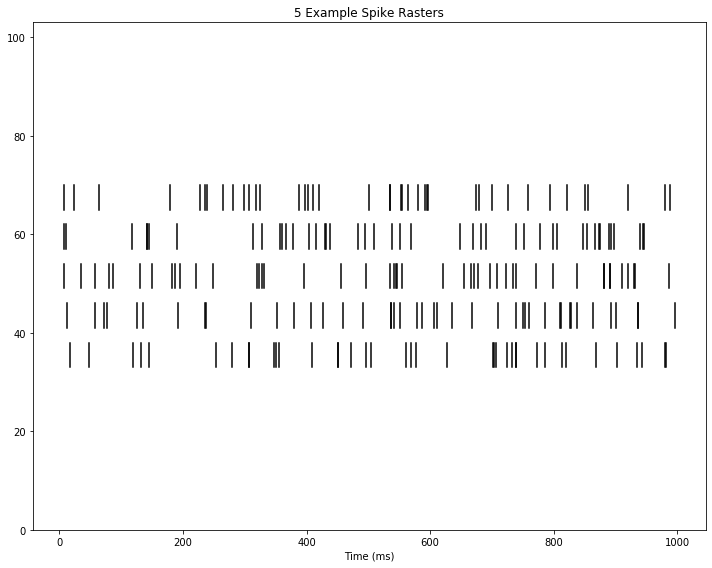

In [4]:
## 3a
num_trials = 100 # number of total spike trains
num_rasters_to_plot = 5 # number of spike trains to plot
#====================================================#
# YOUR CODE HERE:
#   Generate the spike times for 100 trials of an inhomogeneous
#   Poisson process.  Plot 5 example spike rasters.
#====================================================#
# Stores all 100 spike trains
inhom_spike_times = np.zeros((num_trials), dtype = list) 

for trial in range(num_trials):
    # Generate homogeneous Poisson Process, removing first time of 0.0
    homogeneous_spike_train = nsp.GeneratePoissonSpikeTrain(T, r_max)[1:]
    inhom_spike_train = np.empty(0) # Stores inhomogeneous spike train
    
    for spike in homogeneous_spike_train:
        s = ((spike / 1000.0) ** 2.0) * np.pi # Calculate s(t)
        l = r_0 + (r_max - r_0) * np.cos(s - s_max)
        
        threshold = l / r_max # Probability we keep the spike
        u = np.random.uniform(0, 1) # Sample from uniform distribution
        
        if (threshold >= u): # In this case keep the spike
            inhom_spike_train = np.append(inhom_spike_train, spike)
            
    inhom_spike_times[trial] = inhom_spike_train

# Plot five example spike rasters
plt.figure(figsize = (10, 8))
nsp.PlotSpikeRaster(inhom_spike_times[0:num_rasters_to_plot])
    
plt.title("5 Example Spike Rasters")
plt.tight_layout()
#====================================================#
# END YOUR CODE
#====================================================#

### (b) (5 points) Spike histogram
  Plot the spike histogram by taking spike counts in non-overlapping
  20 ms bins, then averaging across the 100 trials.  The spike
  histogram should have firing rate (in spikes / second) as the
  vertical axis and time (in msec, not time bin index) as the
  horizontal axis. Plot the expected firing rate profile defined by equations
 tuning equation and *s(t)* equation on the same plot. 

Text(0.5, 0, 'Time(ms)')

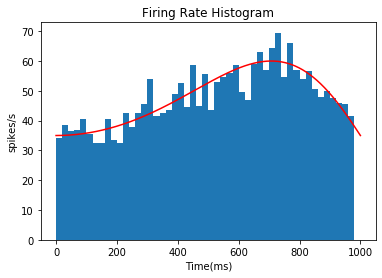

In [5]:
# 3b
bin_width = 20 # (ms)
#====================================================#
# YOUR CODE HERE:
#   Plot the spike histogram
#====================================================#
b = [i * 20 for i in range(50)] # Creates bin list
hist_values = np.zeros(49) # Creates empty numpy array

for trial in range(num_trials):
    hist, bin_edges = np.histogram(inhom_spike_times[trial], b)
    hist_values = np.add(hist_values, hist)

# Plot the tuning curve
x_axis = np.linspace(0, 1000, 1000)
tuning_x = np.empty(0) # Stores tuning curve parameters

for x in np.linspace(0, 1, 1000):
    tuning_x = np.append(tuning_x, (x ** 2) * np.pi)
    
tuning_y = r_0 + (r_max - r_0) * np.cos(tuning_x - s_max)

# Divide by 100 (trials), divide by 0.02 (20 milliseconds)
hist_values = np.divide(hist_values, 2.0) 
plt.bar(bin_edges[:-1], hist_values, width = bin_width, align = "edge")

# Plot the tuning curve
plt.plot(x_axis, tuning_y, c = "red")
plt.title("Firing Rate Histogram")
#====================================================#
# END YOUR CODE
#====================================================#
plt.ylabel('spikes/s')
plt.xlabel('Time(ms)')

#### Question:
Does the spike histogram agree with the expected firing rate profile?

#### Your Answer: It appears to agree reasonably well with the expected firing rate profile. The rate increases to a maximum between 600-800 ms, and then levels off.

### (c) (6 points) Count distribution
  For each trial, count the number of spikes across the entire trial.
  Plot the normalized distribution of spike counts.  Fit a Poisson
  distribution to this empirical distribution and plot it on top of
  the empirical distribution.  

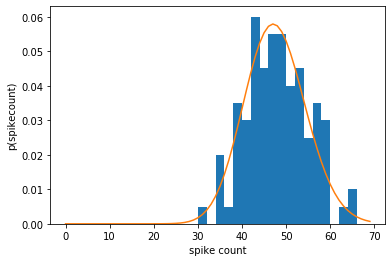

In [6]:
#====================================================#
# YOUR CODE HERE:
#   Plot the normalized distribution of spike counts
#====================================================#
spike_counts = [] # Stores spike count for all trials

for trial in range(num_trials):
    spike_counts.append(len(inhom_spike_times[trial])) # Append trial count

mu = sum(spike_counts) / float(len(spike_counts)) # Calculate mean count
k = [i for i in range(70)]
poison = [((mu ** k) * np.exp(-mu)) / np.math.factorial(k) for k in k]

b = [i*2 for i in range(35)] # Create bin list
plt.hist(spike_counts, bins = b, density = True) # Plot histogram of spike counts
plt.plot(k, poison) # Plot the Poisson distribution
#====================================================#
# END YOUR CODE
#====================================================#
plt.xlabel('spike count')
plt.ylabel('p(spikecount)')
plt.show()

#### Question:
Should we expect the spike counts to be Poisson-distributed?

#### Your Answer: I believe we should expect the spike counts to be Poisson-distributed. As the data originates from the inhomogeneous Poisson process, the spikes are still distributed according to a Poisson distribution.

### (d) (5 points) ISI distribution
  Plot the normalized distribution of ISIs.  Fit an exponential
  distribution to the empirical distribution and plot it on top of the
  empirical distribution. 

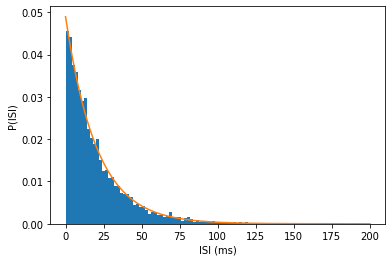

In [7]:
#====================================================#
# YOUR CODE HERE:
#   Plot the normalized distribution of ISIs
#====================================================#
isi_times = [] # List to keep track of all ISI times
for trial in range(num_trials):
    train = inhom_spike_times[trial] # Obtains the spike train for one trial
    
    # Calculate ISI intervals from spike times
    for i in range(len(train)):
        if i == 0:
            isi_times.append(train[i]) # Append first time
        else:
            t_isi = train[i] - train[i - 1] # Calculate the interspike interval
            isi_times.append(t_isi) # Append ISI time to list

mean_isi = sum(isi_times) / len(isi_times) # Calculates average ISI time
l = 1.0 / mean_isi # Exponential lambda is reciprocal of the mean
x = np.linspace(0, 200, 400)
exponential = l * np.exp(-l * x) # Calculates exponential distribution

b = [i * 2 for i in range(100)]
plt.hist(isi_times, bins = b, density = True) # Plot histogram of ISI times
plt.plot(x, exponential) # Plot exponential distribution        
#====================================================#
# END YOUR CODE
#====================================================#
plt.xlabel('ISI (ms)')
plt.ylabel('P(ISI)')
plt.show()

#### Question: 
Should we expect the ISIs to be exponentially-distributed?
(Note, it is possible for the  empirical distribution to strongly resemble an exponential distribution even if the data aren't exponentially distributed.)

#### Your Answer: While we do see the empirical distribution to strongly resemble an exponential distribution, we know from our course concepts that for an inhomogeneous Poisson process, the ISI times are not exponentially distributed.